In [1]:
import os
import openml
import joblib
import shutil
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy as copy
from joblib import Parallel, delayed
from xgboost import XGBClassifier as XGBC
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.calibration import CalibratedClassifierCV as CCCV
from sklearn.metrics import average_precision_score, roc_auc_score

openml.config.apikey = "4ef25cfe971a3731fddbe4fb2f6d1d98"

#### 1. Setting up experimental parameters

In [2]:
data_folder = os.getcwd() + "/datasets/"
learning_folder = os.getcwd() + "/learning/"
detection_folder = os.getcwd() + "/detection/"
learning_results_folder = os.getcwd() + "/learning_results/"
detection_results_folder = os.getcwd() + "/detection_results/"

seeds = range(10)
rho_ys = [5, 10, 15, 20, 25, 30, 35, 40]
rho_xs = [0, 5, 10, 15, 20, 25, 30, 35, 40]
dids = [40710, 53, 40690, 335, 1495, 41143, 1510, 40705, 1462, 1504]

#### 2. Generating datasets and noise

In [3]:
def in_apply(z):
    # this function is required by XGBoost
    # since it cannot handle dummy_variables well
    # dummy names cannot contain "<" nor ","
    try:
        return (z.replace("<", "lt")).replace(",", "c")
    except:
        return z
def parallel_setup(seed, did_folder, X, y, df, attribute_names, categorical_indicator, y_pos, y_neg, X_clean_pos, X_clean_neg):
    seed_folder = did_folder + "seed=" + str(seed) + "/"
    try:
        os.mkdir(seed_folder)
    except:
        pass
        #shutil.rmtree(seed_folder)
        #os.mkdir(seed_folder)
    np.random.seed(seed)
    for rho_y_prct in [5, 10, 15, 20, 25, 30, 35, 40]:
        rho_y_folder = seed_folder + "y=" + str(rho_y_prct) + "/"
        try:
            os.mkdir(rho_y_folder)
        except:
            pass
            #shutil.rmtree(rho_y_folder)
            #os.mkdir(rho_y_folder)
        rho_y = rho_y_prct/100
        # number of instances to label swap
        rho_y_pos_n = int(np.ceil(rho_y*X_clean_pos.shape[0]))
        rho_y_neg_n = int(np.ceil(rho_y*X_clean_neg.shape[0]))
        for rho_x_prct in [0, 5, 10, 15, 20, 25, 30, 35, 40]:
            rho_x_folder = rho_y_folder + "x=" + str(rho_x_prct) + "/"
            try:
                os.mkdir(rho_x_folder)
            except:
                pass
                #shutil.rmtree(rho_x_folder)
                #os.mkdir(rho_x_folder)
            rho_x = rho_x_prct/100
            # number of attributes to swap
            rho_x_n = int(np.ceil(rho_x*X.shape[1]))
            # label-swap instance locations (index)
            rho_y_pos_loc = np.random.choice(X_clean_pos.index, rho_y_pos_n, replace=False) # will be present in X_noisy_neg
            rho_y_neg_loc = np.random.choice(X_clean_neg.index, rho_y_neg_n, replace=False) # will be present in X_noisy_pos    
            if rho_x_n == 0:
                # no attribute replacement is required, only label swap
                corrupted_df = copy(df)
                corrupted_df.loc[rho_y_pos_loc, "class"] = y_neg
                corrupted_df.loc[rho_y_neg_loc, "class"] = y_pos
                # saving corrupted df
                joblib.dump(corrupted_df, rho_x_folder + "corrupted_df.pkl")
                corrupted_df.to_csv(rho_x_folder + "corrupted_df.csv", index=False)
            else:
                X_noisy_pos = pd.concat((
                    copy(X.loc[rho_y_neg_loc]), # getting swap examples from other class
                    copy(X_clean_pos.drop(labels=rho_y_pos_loc)) # dropping examples that are given to other class
                ))
                X_noisy_neg = pd.concat((
                    copy(X.loc[rho_y_pos_loc]), # getting swap examples from other class
                    copy(X_clean_neg.drop(labels=rho_y_neg_loc)) # dropping examples that are given to other class
                ))
                # random selection
                # each label-swapped instance has its own set of random attributes to replace
                random_clean_X = copy(X)
                random_noisy_X = copy(X)
                for rho_y_pos_index in rho_y_pos_loc:
                    replace_attribute_indexs = np.random.choice(range(X.shape[1]), rho_x_n, replace=False)
                    replace_attribute_names = attribute_names[replace_attribute_indexs]
                    replace_categorical_indicators = categorical_indicator[replace_attribute_indexs]
                    # for each attribute being replaced
                    clean_replacement_values = []
                    for i in range(rho_x_n):
                        replace_attribute_name = replace_attribute_names[i]
                        replace_categorical_indicator = replace_categorical_indicators[i]
                        if replace_categorical_indicator:
                            # is categorical
                            clean_replacement_value = np.random.choice(X_clean_neg[replace_attribute_name], 1)
                        else:
                            # is numerical
                            clean_mu = np.mean(X_clean_neg[replace_attribute_name])
                            clean_sig = np.std(X_clean_neg[replace_attribute_name], ddof=1)
                            clean_replacement_value = np.random.normal(clean_mu, clean_sig, 1)
                        clean_replacement_values += [clean_replacement_value[0]]
                    random_clean_X.loc[rho_y_pos_index, replace_attribute_names] = clean_replacement_values
                    
                for rho_y_neg_index in rho_y_neg_loc:
                    replace_attribute_indexs = np.random.choice(range(X.shape[1]), rho_x_n, replace=False)
                    replace_attribute_names = attribute_names[replace_attribute_indexs]
                    replace_categorical_indicators = categorical_indicator[replace_attribute_indexs]
                    # for each attribute being replaced
                    clean_replacement_values = []
                    for i in range(rho_x_n):
                        replace_attribute_name = replace_attribute_names[i]
                        replace_categorical_indicator = replace_categorical_indicators[i]
                        if replace_categorical_indicator:
                            # is categorical
                            clean_replacement_value = np.random.choice(X_clean_pos[replace_attribute_name], 1)
                        else:
                            # is numerical
                            clean_mu = np.mean(X_clean_pos[replace_attribute_name])
                            clean_sig = np.std(X_clean_pos[replace_attribute_name], ddof=1)
                            clean_replacement_value = np.random.normal(clean_mu, clean_sig, 1)
                        clean_replacement_values += [clean_replacement_value[0]]
                    random_clean_X.loc[rho_y_neg_index, replace_attribute_names] = clean_replacement_values
                corrupted_clean_df = pd.concat((copy(random_clean_X), copy(y)), axis=1)
                corrupted_clean_df.loc[rho_y_pos_loc, "class"] = y_neg
                corrupted_clean_df.loc[rho_y_neg_loc, "class"] = y_pos
                joblib.dump(corrupted_clean_df, rho_x_folder + "corrupted_df.pkl")
                corrupted_clean_df.to_csv(rho_x_folder + "corrupted_df.csv", index=False)

try:
    os.mkdir(data_folder)
except:
    shutil.rmtree(data_folder)
    os.mkdir(data_folder)    
for did in tqdm(dids):
    did_folder = data_folder + "did=" + str(did) + "/"
    try:
        os.mkdir(did_folder)
    except:
        pass
        #shutil.rmtree(did_folder)
        #os.mkdir(did_folder)
    dataset = openml.datasets.get_dataset(did)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format='dataframe',
        target=dataset.default_target_attribute
    )
    categorical_indicator = np.array(categorical_indicator)
    attribute_names = np.array(range(X.shape[1])).astype(str)
    X.columns = attribute_names
    
    X = X.apply(lambda x: x.apply(lambda v: in_apply(v)))
    
    df = pd.concat((copy(X), copy(y)), axis=1)
    df.columns = attribute_names.tolist() + ["class"]
    y = copy(df["class"])
    
    joblib.dump(df, did_folder+"df.pkl")
    df.to_csv(did_folder+"df.csv", index=False)
    joblib.dump(categorical_indicator, did_folder+"categorical_indicator.pkl")
    
    y_pos, y_neg = y.unique()
    X_clean_pos = copy(X.loc[y==y_pos]) # clean positive attributes
    X_clean_neg = copy(X.loc[y==y_neg]) # clean negative attributes
    
    Parallel(n_jobs=len(seeds), backend="loky")(
        delayed(parallel_setup)(
            seed=copy(seed),
            did_folder=copy(did_folder),
            X=copy(X),
            y=copy(y),
            df=copy(df),
            attribute_names=copy(attribute_names),
            categorical_indicator=copy(categorical_indicator),
            y_pos=copy(y_pos),
            y_neg=copy(y_neg),
            X_clean_pos=copy(X_clean_pos),
            X_clean_neg=copy(X_clean_neg),
        ) for seed in seeds
    )
    # train-test splits
    skf = SKF(n_splits=10, random_state=42, shuffle=True)
    did_folder = data_folder + "did=" + str(did) + "/"
    df = joblib.load(did_folder + "df.pkl")
    # indices are in range(0, n)
    split_counter = 0
    for train_index, test_index in skf.split(df, df["class"]):
        joblib.dump(test_index, did_folder + "test_index_" + str(split_counter) + ".pkl")
        joblib.dump(train_index, did_folder + "train_index_" + str(split_counter) + ".pkl")
        split_counter += 1

  0%|          | 0/10 [00:00<?, ?it/s]

#### 3. Classifier learning task

  0%|          | 0/7200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

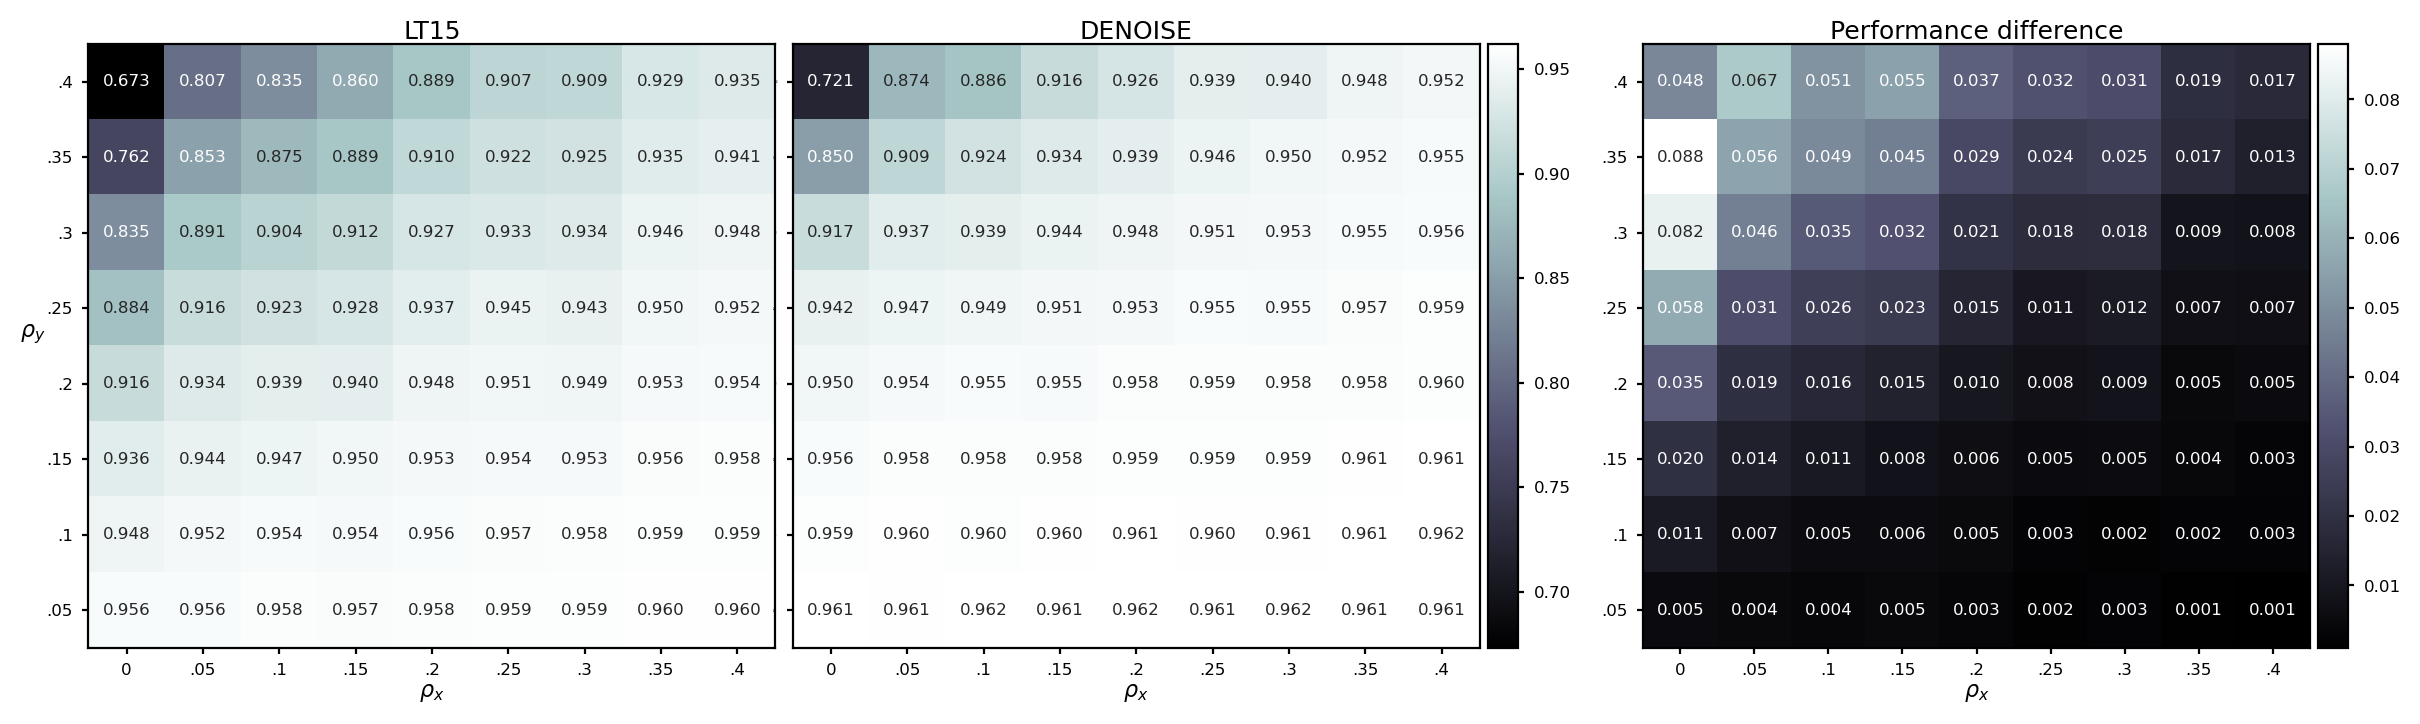

In [4]:
def run_learning_parallel(param, data_folder, learning_folder):
    did, seed, rho_y, rho_x = param
    clean_df_path = data_folder+"did="+str(did)+"/df.pkl"
    corrupted_df_path = data_folder + \
        "did="+str(did)+"/" + \
        "seed="+str(seed)+"/" + \
        "y="+str(rho_y)+"/" + \
        "x="+str(rho_x)+"/corrupted_df.pkl"
    
    clean_df = joblib.load(clean_df_path)
    corrupted_df = joblib.load(corrupted_df_path)
    
    X_corr = pd.get_dummies(corrupted_df[corrupted_df.columns[:-1]])
    y_corr = corrupted_df["class"].copy()
    
    #X_clean = pd.get_dummies(clean_df[clean_df.columns[:-1]])
    y_clean = clean_df["class"].copy()
    
    xp_weights_df = corrupted_df[[]].copy()
    tp_weights_df = corrupted_df[[]].copy()
    posterior_df = corrupted_df[[]].copy()
    y_pos, y_neg = clean_df["class"].unique()
    
    # grabbing posteriors for each training set (10 total)
    for split_counter in range(10):
        #test_index = joblib.load(data_folder+"did="+str(did)+"/test_index_"+str(split_counter)+".pkl")
        train_index = joblib.load(data_folder+"did="+str(did)+"/train_index_"+str(split_counter)+".pkl")
        
        X_train = X_corr.loc[train_index]
        y_train = y_corr.loc[train_index]
        
        skf = SKF(n_splits=10, random_state=42, shuffle=True)
        for sub_train_index, sub_test_index in skf.split(X_train, y_train):

            calib_test_index = train_index[sub_test_index]
            calib_train_index = train_index[sub_train_index]

            X_calib_test = X_corr.loc[calib_test_index]
            y_calib_test = y_corr.loc[calib_test_index]
            X_calib_train = X_corr.loc[calib_train_index]
            y_calib_train = y_corr.loc[calib_train_index]

            clf = CCCV(
                method="sigmoid",
                base_estimator=XGBC(
                    objective="binary:logistic", eval_metric="logloss",
                    random_state=42, n_jobs=1, use_label_encoder=False
                ),
                cv=SKF(n_splits=10, random_state=42, shuffle=True)
            )

            clf.fit(X_calib_train, (y_calib_train==y_pos).astype(int))
            posterior_df.loc[calib_test_index[y_calib_test==y_neg], split_counter] = clf.predict_proba(X_calib_test)[y_calib_test==y_neg, 0]
            posterior_df.loc[calib_test_index[y_calib_test==y_pos], split_counter] = clf.predict_proba(X_calib_test)[y_calib_test==y_pos, 1]
        
        # compute weights
        
        # xp weights ---> log_odds of posterior
        xp_weights_df.loc[train_index, split_counter] = np.log(
            posterior_df.loc[train_index, split_counter] / (1 - posterior_df.loc[train_index, split_counter])
        )
        
        # noise ratio estimates
        rho_pos = min(
            posterior_df.loc[train_index, split_counter][y_train==y_neg].tolist() + \
            (1 - posterior_df.loc[train_index, split_counter][y_train==y_pos]).tolist()
        )
        rho_neg = min(
            posterior_df.loc[train_index, split_counter][y_train==y_pos].tolist() + \
            (1 - posterior_df.loc[train_index, split_counter][y_train==y_neg]).tolist()
        )
        
        # density ratio weights
        tp_weights_df.loc[train_index[y_train==y_pos], split_counter] = (
            posterior_df.loc[train_index[y_train==y_pos], split_counter] - rho_neg
        ) / (
            (1 - rho_neg - rho_pos)*(posterior_df.loc[train_index[y_train==y_pos], split_counter])
        )
        
        tp_weights_df.loc[train_index[y_train==y_neg], split_counter] = (
            posterior_df.loc[train_index[y_train==y_neg], split_counter] - rho_pos
        ) / (
            (1 - rho_neg - rho_pos)*(posterior_df.loc[train_index[y_train==y_neg], split_counter])
        ) 
        
    posterior_df_path = learning_folder + \
        "did="+str(did)+"_" + \
        "seed="+str(seed)+"_" + \
        "y="+str(rho_y)+"_" + \
        "x="+str(rho_x)+"_df.pkl"
    
    xp_weights_df_path = learning_folder + \
        "did="+str(did)+"_" + \
        "seed="+str(seed)+"_" + \
        "y="+str(rho_y)+"_" + \
        "x="+str(rho_x)+"_xp_df.pkl"
    
    tp_weights_df_path = learning_folder + \
        "did="+str(did)+"_" + \
        "seed="+str(seed)+"_" + \
        "y="+str(rho_y)+"_" + \
        "x="+str(rho_x)+"_tp_df.pkl"
    
    joblib.dump(posterior_df, posterior_df_path)
    joblib.dump(xp_weights_df, xp_weights_df_path)
    joblib.dump(tp_weights_df, tp_weights_df_path)
def get_did_seed_learning_results_parallel(param, rho_ys, rho_xs, data_folder, learning_folder, learning_results_folder):
    did, seed = param
    did_folder = data_folder+"did="+str(did)+"/"
    clean_df_path = did_folder + "df.pkl"
    clean_df = joblib.load(clean_df_path)
    y_pos, y_neg = clean_df["class"].unique()
    X_clean = pd.get_dummies(clean_df[clean_df.columns[:-1]].copy())
    y_clean = clean_df["class"].copy()
    
    xp_did_seed_learning_performance_df = pd.DataFrame(
        index=copy(rho_ys),
        columns=copy(rho_xs)
    )

    tp_did_seed_learning_performance_df = pd.DataFrame(
        index=copy(rho_ys),
        columns=copy(rho_xs)
    )
    
    for rho_y in rho_ys:
        for rho_x in rho_xs:
            xp_auc = 0
            tp_auc = 0
            
            corrupted_df_path = data_folder + \
                "did="+str(did)+"/" + \
                "seed="+str(seed)+"/" + \
                "y="+str(rho_y)+"/" + \
                "x="+str(rho_x)+"/corrupted_df.pkl"
            
            xp_df_path = learning_folder + \
                "did="+str(did)+"_" + \
                "seed="+str(seed)+"_" + \
                "y="+str(rho_y)+"_" + \
                "x="+str(rho_x)+"_xp_df.pkl"
            
            tp_df_path = learning_folder + \
                "did="+str(did)+"_" + \
                "seed="+str(seed)+"_" + \
                "y="+str(rho_y)+"_" + \
                "x="+str(rho_x)+"_tp_df.pkl"
            
            corrupted_df = joblib.load(corrupted_df_path)
            xp_df = joblib.load(xp_df_path)
            tp_df = joblib.load(tp_df_path)
            
            X = pd.get_dummies(corrupted_df[corrupted_df.columns[:-1]].copy())
            y = corrupted_df["class"].copy()
        
            for split_counter in range(10):
                test_index = joblib.load(did_folder + "test_index_" +str(split_counter)+ ".pkl")
                train_index = joblib.load(did_folder + "train_index_" +str(split_counter)+ ".pkl")
                
                X_train, y_train = X.loc[train_index].copy(), y.loc[train_index].copy()
                X_test, y_test = X_clean.loc[test_index].copy(), y_clean.loc[test_index].copy()
                
                xp_weights = xp_df.loc[train_index, split_counter]
                tp_weights = tp_df.loc[train_index, split_counter]
                
                xp_clf = XGBC(
                    objective="binary:logistic", eval_metric="logloss",
                    random_state=42, n_jobs=1, use_label_encoder=False
                )
                tp_clf = XGBC(
                    objective="binary:logistic", eval_metric="logloss",
                    random_state=42, n_jobs=1, use_label_encoder=False
                )
                
                xp_clf.fit(X_train, (y_train==y_pos).astype(int), sample_weight=xp_weights)
                tp_clf.fit(X_train, (y_train==y_pos).astype(int), sample_weight=tp_weights)
                
                xp_y_score = xp_clf.predict_proba(X_test)[:, 1]
                tp_y_score = tp_clf.predict_proba(X_test)[:, 1]

                xp_auc += roc_auc_score(y_test==y_pos, xp_y_score)
                tp_auc += roc_auc_score(y_test==y_pos, tp_y_score)
            
            xp_auc /= 10
            tp_auc /= 10
            
            xp_did_seed_learning_performance_df.loc[rho_y, rho_x] = xp_auc
            tp_did_seed_learning_performance_df.loc[rho_y, rho_x] = tp_auc
    
    xp_did_seed_learning_performance_df_path = learning_results_folder + \
        "did="+str(did)+"_" + \
        "seed="+str(seed)+"_xp_df.pkl"
    
    tp_did_seed_learning_performance_df_path = learning_results_folder + \
        "did="+str(did)+"_" + \
        "seed="+str(seed)+"_tp_df.pkl"
    
    joblib.dump(xp_did_seed_learning_performance_df, xp_did_seed_learning_performance_df_path)
    joblib.dump(tp_did_seed_learning_performance_df, tp_did_seed_learning_performance_df_path)
def make_learning_results_figure(dids, seeds, learning_results_folder):
    xp_learning_performance_df = 0
    tp_learning_performance_df = 0

    for did in dids:
        xp_did_learning_performance_df = 0
        tp_did_learning_performance_df = 0
        for seed in seeds:
            xp_did_seed_learning_performance_df_path = learning_results_folder + \
                "did="+str(did)+"_" + \
                "seed="+str(seed)+"_xp_df.pkl"

            tp_did_seed_learning_performance_df_path = learning_results_folder + \
                "did="+str(did)+"_" + \
                "seed="+str(seed)+"_tp_df.pkl"

            xp_did_learning_performance_df += joblib.load(xp_did_seed_learning_performance_df_path)
            tp_did_learning_performance_df += joblib.load(tp_did_seed_learning_performance_df_path)

        xp_did_learning_performance_df /= len(seeds)
        tp_did_learning_performance_df /= len(seeds)
        xp_learning_performance_df += xp_did_learning_performance_df
        tp_learning_performance_df += tp_did_learning_performance_df

    xp_learning_performance_df /= len(dids)
    tp_learning_performance_df /= len(dids)

    xp_learning_performance_df[::] = xp_learning_performance_df.values.astype(float)
    tp_learning_performance_df[::] = tp_learning_performance_df.values.astype(float)

    tp_fig_df = tp_learning_performance_df.loc[tp_learning_performance_df.index[::-1]].copy()
    tp_fig_df.index = [".4", ".35", ".3", ".25", ".2", ".15", ".1", ".05"]
    tp_fig_df.columns = ["0", ".05", ".1", ".15", ".2", ".25", ".3", ".35", ".4"]

    xp_fig_df = xp_learning_performance_df.loc[xp_learning_performance_df.index[::-1]].copy()
    xp_fig_df.index = [".4", ".35", ".3", ".25", ".2", ".15", ".1", ".05"]
    xp_fig_df.columns = ["0", ".05", ".1", ".15", ".2", ".25", ".3", ".35", ".4"]

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), dpi=200, sharex=True, sharey=False)
    plt.subplots_adjust(wspace = 0.025)

    dec_places = 3
    vmin = min(
        tp_fig_df.round(dec_places).min().min(),
        xp_fig_df.round(dec_places).min().min()
    )
    vmax = max(
        tp_fig_df.round(dec_places).max().max(),
        xp_fig_df.round(dec_places).max().max()
    )

    diff_vmin = (
        xp_fig_df - tp_fig_df
    ).round(dec_places).min().min()


    diff_vmax = (
        xp_fig_df - tp_fig_df
    ).round(dec_places).max().max()

    fig_datas = [tp_fig_df, xp_fig_df]
    for i in range(len(fig_datas)):
        fig_df = fig_datas[i]
        sb.heatmap(
            fig_df,
            annot=True,
            fmt="."+str(dec_places)+"f",
            annot_kws=dict(size=6),
            vmin=vmin, vmax=vmax, ax=axs[i],
            cbar=False,
            cmap="bone"
        )
        axs[i].tick_params(length=2, which="both")
        for _, spine in axs[i].spines.items():
            spine.set_visible(True)
        for tick in axs[i].xaxis.get_major_ticks():
            tick.label.set_fontsize(6)
            tick.label.set_rotation(0)
        for tick in axs[i].yaxis.get_major_ticks():
            tick.label.set_fontsize(6)
            tick.label.set_rotation(0)

    axs[1].tick_params(length=2, which="both")
    for _, spine in axs[1].spines.items():
        spine.set_visible(True)
    for tick in axs[1].xaxis.get_major_ticks():
        tick.label.set_fontsize(6)
        tick.label.set_rotation(0)
    for tick in axs[1].yaxis.get_major_ticks():
        tick.label.set_fontsize(0)
        tick.label.set_rotation(0)

    sb.heatmap(
        xp_fig_df - tp_fig_df,
        annot=True,
        fmt="."+str(dec_places)+"f",
        annot_kws=dict(size=6),
        vmin=diff_vmin, vmax=diff_vmax, ax=axs[2],
        cbar=False,
        cmap="bone"
    )
    axs[2].tick_params(length=2, which="both")
    for _, spine in axs[2].spines.items():
        spine.set_visible(True)
    for tick in axs[2].xaxis.get_major_ticks():
        tick.label.set_fontsize(6)
        tick.label.set_rotation(0)
    for tick in axs[2].yaxis.get_major_ticks():
        tick.label.set_fontsize(6)
        tick.label.set_rotation(0)

    axs[0].set_title("LT15", fontsize=9, pad=0.5)
    axs[1].set_title("DENOISE", fontsize=9, pad=0.5, variant="small-caps")
    axs[2].set_title("Performance difference", fontsize=9, pad=0.5)

    axs[0].set_ylabel(r"$\rho_y$", fontsize=8, rotation=0, labelpad=5)
    axs[0].set_xlabel(r"$\rho_x$", fontsize=8, rotation=0, labelpad=1)
    axs[1].set_xlabel(r"$\rho_x$", fontsize=8, rotation=0, labelpad=1)
    axs[2].set_xlabel(r"$\rho_x$", fontsize=8, rotation=0, labelpad=1)

    cmap="bone"
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=axs[:2], use_gridspec=False, pad=0.005)
    cbar.ax.tick_params(labelsize=6, length=2) 
    cbar.outline.set_visible(True)

    cmap="bone"
    norm = mpl.colors.Normalize(vmin=diff_vmin,vmax=diff_vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=axs[-1], use_gridspec=False, anchor=(-1.4,0.5))
    cbar.ax.tick_params(labelsize=6, length=2) 
    cbar.outline.set_visible(True)

    box = axs[2].get_position()
    box.x0 = box.x0 - .035
    box.x1 = box.x1 - .030
    axs[2].set_position(box)
    
    plt.savefig("learning_3heatmaps.svg", format="svg")
    plt.show()

try:
    os.mkdir(learning_folder)
except:
    pass
params = list(product(dids, seeds, rho_ys, rho_xs))
experiments = Parallel(n_jobs=-1, backend="loky")(
    delayed(run_learning_parallel)(
        param=copy(param),
        data_folder=copy(data_folder),
        learning_folder=copy(learning_folder)
    ) for param in tqdm(params)
)

try:
    os.mkdir(learning_results_folder)
except:
    pass
params = list(product(dids, seeds))
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(get_did_seed_learning_results_parallel)(
        param=copy(param),
        rho_ys=copy(rho_ys),
        rho_xs=copy(rho_xs),
        data_folder=copy(data_folder),
        learning_folder=copy(learning_folder),
        learning_results_folder=copy(learning_results_folder)
    ) for param in tqdm(params)
)

make_learning_results_figure(dids, seeds, learning_results_folder)

#### 4. Noise detection task

  0%|          | 0/7200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

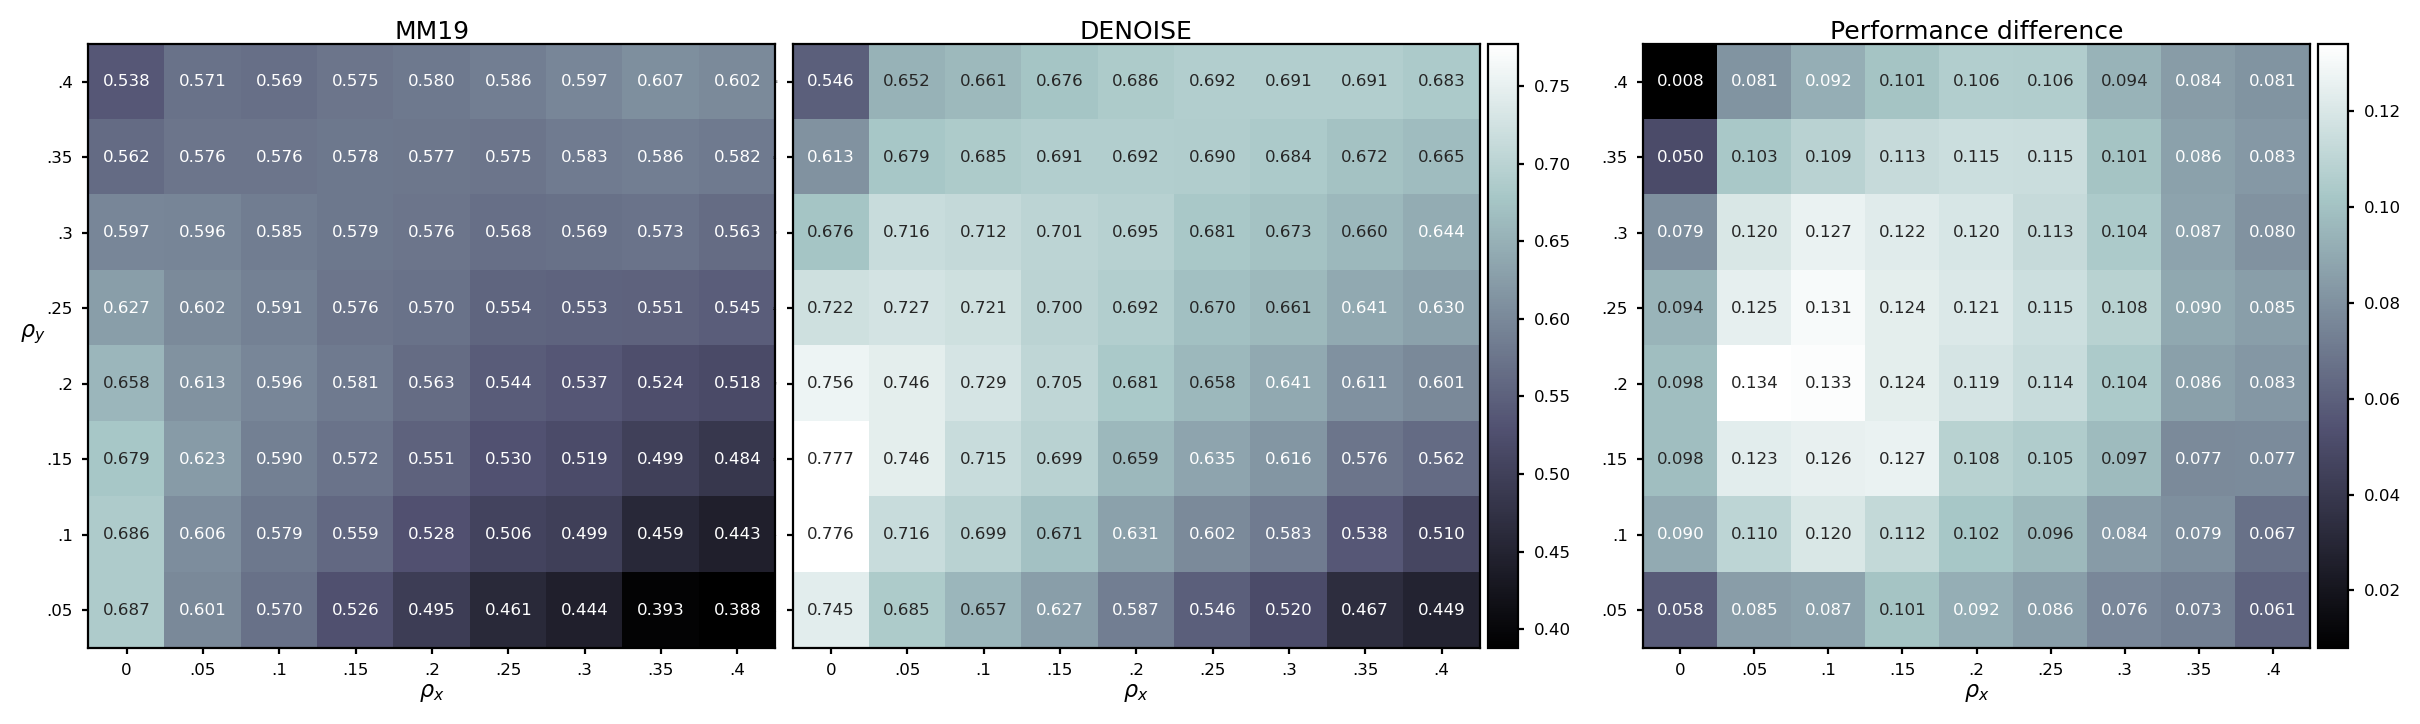

In [5]:
def run_detection_parallel(param, data_folder, detection_folder):
    did, seed, rho_y, rho_x = param
    clean_df_path = data_folder+"did="+str(did)+"/df.pkl"
    corrupted_df_path = data_folder + \
        "did="+str(did)+"/" + \
        "seed="+str(seed)+"/" + \
        "y="+str(rho_y)+"/" + \
        "x="+str(rho_x)+"/corrupted_df.pkl"
    
    clean_df = joblib.load(clean_df_path)
    corrupted_df = joblib.load(corrupted_df_path)
    X = pd.get_dummies(corrupted_df[corrupted_df.columns[:-1]])
    
    posterior_df = corrupted_df[[]].copy()
    y_pos, y_neg = clean_df["class"].unique()
    
    # "raw"
    clf = XGBC(
        objective="binary:logistic", eval_metric="logloss",
        random_state=42, n_jobs=1, use_label_encoder=False
    )
    clf.fit(X, (corrupted_df["class"]==y_pos).astype(int))
    posterior_df.loc[corrupted_df["class"]==y_neg, "raw"] = clf.predict_proba(X)[corrupted_df["class"]==y_neg, 0]
    posterior_df.loc[corrupted_df["class"]==y_pos, "raw"] = clf.predict_proba(X)[corrupted_df["class"]==y_pos, 1]
    
    # "xp"
    for split_counter in range(10):
        test_index = joblib.load(data_folder+"did="+str(did)+"/test_index_"+str(split_counter)+".pkl")
        train_index = joblib.load(data_folder+"did="+str(did)+"/train_index_"+str(split_counter)+".pkl")
        
        clf = CCCV(
            method="sigmoid",
            base_estimator=XGBC(
                objective="binary:logistic", eval_metric="logloss",
                random_state=42, n_jobs=1, use_label_encoder=False
            ),
            cv = SKF(n_splits=10, random_state=42, shuffle=True)
        )
        
        X_test = X.loc[test_index]
        X_train = X.loc[train_index]
        y_test = corrupted_df.loc[test_index, "class"]
        y_train = corrupted_df.loc[train_index, "class"]
        
        clf.fit(X_train, (y_train==y_pos).astype(int))
        posterior_df.loc[test_index[y_test==y_neg], "xp"] = clf.predict_proba(X_test)[y_test==y_neg, 0]
        posterior_df.loc[test_index[y_test==y_pos], "xp"] = clf.predict_proba(X_test)[y_test==y_pos, 1]
    
    
    posterior_df_path = detection_folder + \
        "did="+str(did)+"_" + \
        "seed="+str(seed)+"_" + \
        "y="+str(rho_y)+"_" + \
        "x="+str(rho_x)+"_df.pkl"
    joblib.dump(posterior_df, posterior_df_path)
def get_did_seed_detection_results_parallel(param, rho_ys, rho_xs, data_folder, detection_folder, detection_results_folder):
    did, seed = param
    
    clean_df_path = data_folder+"did="+str(did)+"/df.pkl"
    clean_df = joblib.load(clean_df_path)
    
    avp_xp_did_seed_detection_performance_df = pd.DataFrame(
        index=copy(rho_ys),
        columns=copy(rho_xs)
    )

    avp_raw_did_seed_detection_performance_df = pd.DataFrame(
        index=copy(rho_ys),
        columns=copy(rho_xs)
    )
    
    for rho_y in rho_ys:
        for rho_x in rho_xs:

            corrupted_df_path = data_folder + \
                "did="+str(did)+"/" + \
                "seed="+str(seed)+"/" + \
                "y="+str(rho_y)+"/" + \
                "x="+str(rho_x)+"/corrupted_df.pkl"
            detection_df_path = detection_folder + \
                "did="+str(did)+"_" + \
                "seed="+str(seed)+"_" + \
                "y="+str(rho_y)+"_" + \
                "x="+str(rho_x)+"_df.pkl"
            
            corrupted_df = joblib.load(corrupted_df_path)
            detection_df = joblib.load(detection_df_path)
            y_true = clean_df["class"]!=corrupted_df["class"]
            
            xp_y_score = 1 - detection_df["xp"]
            raw_y_score = 1 - detection_df["raw"]
            
            avp_xp_did_seed_detection_performance_df.loc[rho_y, rho_x] = average_precision_score(y_true, xp_y_score)
            avp_raw_did_seed_detection_performance_df.loc[rho_y, rho_x] = average_precision_score(y_true, raw_y_score)
            
    avp_xp_did_seed_detection_performance_df_path = detection_results_folder + \
        "did="+str(did)+"_" + \
        "seed="+str(seed)+"_avp_xp_df.pkl"
    
    avp_raw_did_seed_detection_performance_df_path = detection_results_folder + \
        "did="+str(did)+"_" + \
        "seed="+str(seed)+"_avp_raw_df.pkl"
    
    joblib.dump(avp_xp_did_seed_detection_performance_df, avp_xp_did_seed_detection_performance_df_path)
    joblib.dump(avp_raw_did_seed_detection_performance_df, avp_raw_did_seed_detection_performance_df_path)
def make_detection_results_figure(dids, seeds, detection_results_folder):
    xp_detection_performance_df = 0
    raw_detection_performance_df = 0
    for did in dids:
        xp_did_detection_performance_df = 0
        raw_did_detection_performance_df = 0
        for seed in seeds:

            xp_did_seed_detection_performance_df_path = detection_results_folder + \
                "did="+str(did)+"_" + \
                "seed="+str(seed)+"_avp_xp_df.pkl"

            raw_did_seed_detection_performance_df_path = detection_results_folder + \
                "did="+str(did)+"_" + \
                "seed="+str(seed)+"_avp_raw_df.pkl"

            xp_did_detection_performance_df += joblib.load(xp_did_seed_detection_performance_df_path)
            raw_did_detection_performance_df += joblib.load(raw_did_seed_detection_performance_df_path)

        xp_did_detection_performance_df /= len(seeds)
        raw_did_detection_performance_df /= len(seeds)

        xp_detection_performance_df += xp_did_detection_performance_df
        raw_detection_performance_df += raw_did_detection_performance_df

    xp_detection_performance_df /= len(dids)
    raw_detection_performance_df /= len(dids)

    xp_detection_performance_df[::] = xp_detection_performance_df.values.astype(float)
    raw_detection_performance_df[::] = raw_detection_performance_df.values.astype(float)

    raw_fig_df = raw_detection_performance_df.loc[raw_detection_performance_df.index[::-1]].copy()
    raw_fig_df.index = [".4", ".35", ".3", ".25", ".2", ".15", ".1", ".05"]
    raw_fig_df.columns = ["0", ".05", ".1", ".15", ".2", ".25", ".3", ".35", ".4"]

    xp_fig_df = xp_detection_performance_df.loc[xp_detection_performance_df.index[::-1]].copy()
    xp_fig_df.index = [".4", ".35", ".3", ".25", ".2", ".15", ".1", ".05"]
    xp_fig_df.columns = ["0", ".05", ".1", ".15", ".2", ".25", ".3", ".35", ".4"]

    dec_places = 3
    vmin = min(
        raw_fig_df.round(dec_places).min().min(),
        xp_fig_df.round(dec_places).min().min()
    )
    vmax = max(
        raw_fig_df.round(dec_places).max().max(),
        xp_fig_df.round(dec_places).max().max()
    )
    
    diff_vmin = (
        xp_fig_df - raw_fig_df
    ).round(dec_places).min().min()

      
    diff_vmax = (
        xp_fig_df - raw_fig_df
    ).round(dec_places).max().max()
    
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), dpi=200, sharex=True, sharey=False)
    plt.subplots_adjust(wspace = 0.025) #.025

    sb.heatmap(
        raw_fig_df,
        annot=True,
        fmt="."+str(dec_places)+"f",
        annot_kws=dict(size=6),
        vmin=vmin, vmax=vmax, ax=axs[0],
        cbar=False,
        cmap="bone"
    )
    axs[0].tick_params(length=2, which="both")
    for _, spine in axs[0].spines.items():
        spine.set_visible(True)
    for tick in axs[0].xaxis.get_major_ticks():
        tick.label.set_fontsize(6)
        tick.label.set_rotation(0)
    for tick in axs[0].yaxis.get_major_ticks():
        tick.label.set_fontsize(6)
        tick.label.set_rotation(0)

    sb.heatmap(
        xp_fig_df,
        annot=True,
        fmt="."+str(dec_places)+"f",
        annot_kws=dict(size=6),
        vmin=vmin, vmax=vmax, ax=axs[1],
        cbar=False,
        cmap="bone"
    )
    axs[1].tick_params(length=2, which="both")
    for _, spine in axs[1].spines.items():
        spine.set_visible(True)
    for tick in axs[1].xaxis.get_major_ticks():
        tick.label.set_fontsize(6)
        tick.label.set_rotation(0)
    for tick in axs[1].yaxis.get_major_ticks():
        tick.label.set_fontsize(0)
        tick.label.set_rotation(0)
    
    sb.heatmap(
        xp_fig_df - raw_fig_df,
        annot=True,
        fmt="."+str(dec_places)+"f",
        annot_kws=dict(size=6),
        vmin=diff_vmin, vmax=diff_vmax, ax=axs[2],
        cbar=False,
        cmap="bone"
    )
    axs[2].tick_params(length=2, which="both")
    for _, spine in axs[2].spines.items():
        spine.set_visible(True)
    for tick in axs[2].xaxis.get_major_ticks():
        tick.label.set_fontsize(6)
        tick.label.set_rotation(0)
    for tick in axs[2].yaxis.get_major_ticks():
        tick.label.set_fontsize(6)
        tick.label.set_rotation(0)
    
    axs[0].set_title("MM19", fontsize=9, pad=0.5)
    axs[1].set_title("DENOISE", fontsize=9, pad=0.5, variant="small-caps")
    axs[2].set_title("Performance difference", fontsize=9, pad=0.5)

    axs[0].set_ylabel(r"$\rho_y$", fontsize=8, rotation=0, labelpad=5)
    axs[0].set_xlabel(r"$\rho_x$", fontsize=8, rotation=0, labelpad=1)
    axs[1].set_xlabel(r"$\rho_x$", fontsize=8, rotation=0, labelpad=1)
    axs[2].set_xlabel(r"$\rho_x$", fontsize=8, rotation=0, labelpad=1)

    cmap="bone"
    norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=axs[:2], use_gridspec=False, pad=0.005)
    cbar.ax.tick_params(labelsize=6, length=2) 
    cbar.outline.set_visible(True)
    
    cmap="bone"
    norm = mpl.colors.Normalize(vmin=diff_vmin,vmax=diff_vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = plt.colorbar(sm, ax=axs[-1], use_gridspec=False, anchor=(-1.4,0.5))
    cbar.ax.tick_params(labelsize=6, length=2) 
    cbar.outline.set_visible(True)
    
    box = axs[2].get_position()
    box.x0 = box.x0 - .035
    box.x1 = box.x1 - .030
    axs[2].set_position(box)
    
    plt.savefig("detection_3heatmaps.svg", format="svg")
    plt.show()    

try:
    os.mkdir(detection_folder)
except:
    pass
params = list(product(dids, seeds, rho_ys, rho_xs))
experiments = Parallel(n_jobs=-1, backend="loky")(
    delayed(run_detection_parallel)(
        param=copy(param),
        data_folder=copy(data_folder),
        detection_folder=copy(detection_folder)
    ) for param in tqdm(params)
)

try:
    os.mkdir(detection_results_folder)
except:
    pass
params = list(product(dids, seeds))
results = Parallel(n_jobs=-1, backend="loky")(
    delayed(get_did_seed_detection_results_parallel)(
        param=copy(param),
        rho_ys=copy(rho_ys),
        rho_xs=copy(rho_xs),
        data_folder=copy(data_folder),
        detection_folder=copy(detection_folder),
        detection_results_folder=copy(detection_results_folder)
    ) for param in tqdm(params)
)

make_detection_results_figure(dids, seeds, detection_results_folder)